# Libraries

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
!pip install catboost
!pip install xgboost
!pip install lightgbm
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.3 MB/s eta 0:00:00


In [ ]:
# Machine Learning Models
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.ensemble import VotingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Data Load and Merge

In [ ]:
# Load data
# Assuming data files are in the working directory
internal = pd.read_excel("Vodka (Internal Sales).xlsx")
external = pd.read_excel("Vodka (External Data).xlsx")
store_info = pd.read_excel("Store Information.xlsx", skiprows=1)

In [ ]:
# Data Cleaning

# Drop unnecessary columns from store_df (if any)
store_columns_to_drop = [
    # Add column names to drop if necessary
]
store_df = store_info.drop(columns=store_columns_to_drop)

# Drop columns from external_df
external_df_columns_to_drop = ['category', 'vintage']
external_df = external.drop(columns=external_df_columns_to_drop)

# Drop columns from internal_df
internal_df_columns_to_drop = ['Category']
internal_df = internal.drop(columns=internal_df_columns_to_drop)

# Rename columns in store_df
store_df_clean = store_df.rename(columns={
    'State': 'Store_State',
    'Store Number': 'Store_Number',
    'Store Name': 'Store_Name',
    'Open Date': 'Open_Date',
    'Price Zone/Market': 'Market_Name',
    'Store Address': 'Store_Address',
    'Store Size': 'Store_Size',
    'Households (HH)': 'Households',
    '% HH Income > $100K': 'Perc_HH_Income_above100K',
    'Median HH Income': 'Median_HH_Income',
    'Average Net Worth': 'Average_Net_Worth',
    '% Population w/ Bachelor\'s Degree +': 'Perc_Population_Bachelor_Degree',
    '% Hispanic': 'Perc_Hispanic',
    '% Asian': 'Perc_Asian',
    '% African American': 'Perc_African_American',
    '% Population Age 50-70': 'Perc_Population_Age_50-70'
})

# Rename columns in external_df
external_df_clean = external_df.rename(columns={
    'item_code': 'Item_Code',
    'state': 'Store_State',
    'sales_dollars_L52wk': 'Market_Sales_L52wk',
    'points_of_distribution_L52wk': 'Count_Item_Location',
    'package_type': 'Package_Type',
    'item_name': 'Item_Name'
})

# Rename columns in internal_df
internal_df_clean = internal_df.rename(columns={
    'Store Number': 'Store_Number',
    'Store State': 'Store_State',
    'Item Code': 'Item_Code',
    'Item Name': 'Item_Name',
    'Package Type': 'Package_Type',
    'Retail': 'Retail_Price',
    'L52W in Stock': 'Count_Week_Instock',
    'Normalized Sales $ L52W': 'Normalized_Sales_$L52W'
})

# Merge internal_df_clean with store_df_clean on 'Store_Number'
internal_store_merged_df = pd.merge(internal_df_clean, store_df_clean, on='Store_Number', how='left')

# Drop 'Store_State_y' and rename 'Store_State_x' to 'Store_State'
internal_store_merged_df = internal_store_merged_df.drop(columns=['Store_State_y'])
internal_store_merged_df = internal_store_merged_df.rename(columns={'Store_State_x': 'Store_State'})

# Merge internal_store_merged_df with external_df_clean on ['Store_State', 'Item_Code']
complete_merged_df = pd.merge(internal_store_merged_df, external_df_clean, on=['Store_State', 'Item_Code'], how='left')

# Drop duplicate columns and rename
complete_merged_df = complete_merged_df.drop(columns=['Package_Type_y', 'Item_Name_y'])
complete_merged_df = complete_merged_df.rename(columns={'Item_Name_x': 'Item_Name', 'Package_Type_x': 'Package_Type'})

# Save the merged data
complete_merged_df.to_csv('complete_merged_data.csv', index=False)

# Load 'complete_merged_data.csv'
complete_df = pd.read_csv('complete_merged_data.csv')

In [ ]:
complete_df = pd.read_csv('complete_merged_data.csv')

# Data Processing and Feature Engineering

In [ ]:
# Feature Engineering

# Feature 1: Store age in days
complete_df['Open_Date'] = pd.to_datetime(complete_df['Open_Date'], format='%Y-%m-%d', errors='coerce')
complete_df['Store_Age_Days'] = (datetime.now() - complete_df['Open_Date']).dt.days

# Feature 2: High_Education_High_Income
complete_df['High_Education_High_Income'] = complete_df['Perc_Population_Bachelor_Degree'] * complete_df['Perc_HH_Income_above100K']

# Feature 3: Diversity_Index
complete_df['Diversity_Index'] = complete_df['Perc_Hispanic'] + complete_df['Perc_Asian'] + complete_df['Perc_African_American']

# Feature 4: Age_Income_Ratio
complete_df['Age_Income_Ratio'] = complete_df['Perc_Population_Age_50-70'] / complete_df['Median_HH_Income']

# Feature 5: Price_Per_Household
complete_df['Price_Per_Household'] = complete_df['Retail_Price'] / complete_df['Households']

# Feature 6: Vodka_Sales_Factor
complete_df['Vodka_Sales_Factor'] = complete_df['Vodka'] * complete_df['Retail_Price']

# Feature 7: Household_Income_to_NetWorth_Ratio
complete_df['Household_Income_to_NetWorth_Ratio'] = complete_df['Median_HH_Income'] / complete_df['Average_Net_Worth']

# Feature 8: Household_Vodka_Factor
complete_df['Household_Vodka_Factor'] = complete_df['Households'] * complete_df['Vodka']

# Feature 9: Education_Diversity_Factor
complete_df['Education_Diversity_Factor'] = complete_df['Perc_Population_Bachelor_Degree'] * complete_df['Diversity_Index']

# Feature 10: Diversity_Vodka_Factor
complete_df['Diversity_Vodka_Factor'] = complete_df['Diversity_Index'] * complete_df['Vodka']

# Feature 11: Age_HighIncome_Factor
complete_df['Age_HighIncome_Factor'] = complete_df['Perc_Population_Age_50-70'] * complete_df['Perc_HH_Income_above100K']

# Feature 12: One-hot Encoding Store_Size
complete_df = pd.get_dummies(complete_df, columns=['Store_Size'], prefix='Store_Size')

# Feature 13: Wealth_Diversity_Index
complete_df['Wealth_Diversity_Index'] = complete_df['Average_Net_Worth'] * complete_df['Diversity_Index']

# Feature 14: One-hot Encoding Store_State
complete_df = pd.get_dummies(complete_df, columns=['Store_State'], prefix='Store_State')

# Feature 15: One-hot Encoding Package_Type
complete_df = pd.get_dummies(complete_df, columns=['Package_Type'], prefix='Package_Type')

# Feature 16: Normalize 'Count_Week_Instock'
# First, fill NA's in 'Count_Week_Instock'
complete_df['Count_Week_Instock'] = complete_df.groupby(['Item_Code', 'Market_Name'])['Count_Week_Instock'].transform(
    lambda x: x.fillna(x.median())
)
complete_df['Count_Week_Instock'].fillna(complete_df['Count_Week_Instock'].median(), inplace=True)

# Normalize 'Count_Week_Instock'
scaler = MinMaxScaler()
complete_df['Count_Week_Instock_Normalized'] = scaler.fit_transform(complete_df[['Count_Week_Instock']])

# Replace True/False with 1/0
complete_df = complete_df.replace({True: 1, False: 0})

# Save 'complete_df'
complete_df.to_csv('complete_df.csv', index=False)

# Load 'complete_df.csv'
df_cleaned = pd.read_csv('complete_df.csv')

# Data Preparation
# Function to fill NAs
def fill_NAs(df):
    df_cleaned = df.copy()

    # Fill 'Count_Week_Instock' NAs
    average_l52w = df_cleaned.groupby(['Item_Code', 'Market_Name'])['Count_Week_Instock'].transform('mean')
    df_cleaned['Count_Week_Instock'] = df_cleaned['Count_Week_Instock'].fillna(average_l52w)
    df_cleaned['Count_Week_Instock'].fillna(df_cleaned['Count_Week_Instock'].median(), inplace=True)

    # Fill 'Market_Sales_L52wk' NAs
    df_cleaned['Market_Sales_L52wk'] = df_cleaned.groupby(['Item_Code'])['Market_Sales_L52wk'].transform(
        lambda x: x.fillna(x.mean()))
    df_cleaned['Market_Sales_L52wk'].fillna(
        df_cleaned.groupby(['Item_Code'])['Normalized_Sales_$L52W'].transform('mean'), inplace=True)
    df_cleaned['Market_Sales_L52wk'].fillna(df_cleaned['Market_Sales_L52wk'].median(), inplace=True)

    return df_cleaned

# Apply the function
df_cleaned = fill_NAs(df_cleaned)

# Log transformation
columns_to_log = ['Retail_Price', 'Households', 'Average_Net_Worth', 'Store_Age_Days',
                  'Vodka_Sales_Factor', 'Household_Income_to_NetWorth_Ratio',
                  'Wealth_Diversity_Index', 'Normalized_Sales_$L52W', 'Market_Sales_L52wk']

for column in columns_to_log:
    df_cleaned['log_' + column] = np.log(df_cleaned[column] + 1e-6)

# Create 'Net_Worth_Category'
bins = [df_cleaned["Average_Net_Worth"].min(),
        df_cleaned["Average_Net_Worth"].quantile(0.25),
        df_cleaned["Average_Net_Worth"].quantile(0.5),
        df_cleaned["Average_Net_Worth"].quantile(0.75),
        df_cleaned["Average_Net_Worth"].max()]
labels = ['Low', 'Medium', 'High', 'Very High']
df_cleaned['Net_Worth_Category'] = pd.cut(df_cleaned['Average_Net_Worth'], bins=bins, labels=labels, include_lowest=True)

# Create 'Spirits_Direct' column
total_wine_partners = [
    "Tower Vodka", "Summum Vodka", "Hope Vodka", "Purity Vodka Connoisseur 51", "Classic Club Vodka",
    "The American Plains Vodka", "Froggy B Vodka", "Roberto Cavalli Vodka", "Akva Organic Swedish Vodka",
    "Gallant Vodka", "Opulent Vodka", "Veil Vodka", "Starr Blu Vodka", "Lyna Vodka", "Karkov Vodka",
    "Prairie Organic Vodka", "Pau Maui Handcrafted Vodka", "Eight Degrees Vodka", "Esme Black Shield Vodka",
    "Greenhouse Organic Vodka", "ABK6 Organic Vodka", "Ivanhalder's 1815 Vodka", "Stateside Urbancraft Vodka",
    "3 Howls Blood Orange Vodka"
]
df_cleaned['Spirits_Direct'] = df_cleaned['Item_Name'].apply(
    lambda x: 1 if any(partner in str(x) for partner in total_wine_partners) else 0
)

# Create 'Flavored_Vodka' column
flavor_keywords = [
    # Add flavor keywords as in the original code
    'Apple', 'Apricot', 'Berry', 'Blackberry', 'Blueberry', 'Cherry', 'Citrus', 'Coconut', 'Cranberry',
    'Grape', 'Grapefruit', 'Lemon', 'Lime', 'Mango', 'Melon', 'Orange', 'Peach', 'Pear', 'Pineapple',
    'Raspberry', 'Strawberry', 'Vanilla', 'Watermelon', 'Pepper', 'Chocolate', 'Espresso', 'Coffee',
    'Caramel', 'Honey', 'Cinnamon', 'Peppermint', 'Whipped', 'Cake', 'Marshmallow', 'Butterscotch',
    'vanilla', 'citrus', 'berry', 'peach', 'apple', 'lemon', 'lime', 'orange', 'raspberry',
    'strawberry', 'cherry', 'pineapple', 'mango', 'coconut', 'pepper', 'chocolate', 'caramel',
    'coffee', 'espresso', 'honey', 'ginger', 'melon', 'grape', 'pomegranate', 'watermelon',
    'cucumber', 'peppermint', 'cinnamon', 'spice', 'tea', 'mint', 'cake', 'whipped', 'cream',
    'butterscotch', 'toffee', 'hazelnut', 'almond', 'fig', 'apricot', 'pear', 'passion fruit',
    'kiwi', 'blueberry', 'blackberry', 'cranberry', 'grapefruit', 'tangerine', 'blood orange',
    'hibiscus', 'lavender', 'rose', 'elderflower', 'lychee', 'papaya', 'guava', 'dragonfruit',
    'acai', 'jalapeno', 'chipotle', 'sriracha', 'wasabi', 'bacon', 'smoked', 'maple', 'pumpkin',
    'smores', 'birthday cake', 'cotton candy', 'bubblegum', 'root beer', 'cola', 'gingerbread',
    'candy cane', 'sugar cookie', 'salted caramel', 'pecan', 'walnut', 'macadamia', 'pistachio',
    'chai', 'matcha', 'mocha', 'hazelnut', 'almond', 'butter', 'biscuit', 'cookie', 'brownie',
    'fudge', 'truffle', 'nougat', 'praline', 'marzipan', 'amaretto', 'tiramisu', 'baklava',
    'bakery', 'dessert', 'pastry', 'confection', 'sweet', 'sour', 'spicy', 'herb', 'botanical',
    'infusion', 'essence', 'extract', 'liqueur', 'cordial', 'schnapps'
]
df_cleaned['Flavored_Vodka'] = df_cleaned['Item_Name'].apply(
    lambda x: 1 if any(keyword.lower() in str(x).lower() for keyword in flavor_keywords) else 0
)

# Create 'Top20_Vodka' column
brand_keywords = [
    'Smirnoff', 'Absolut', 'Zubrowka', 'Magic Moments', 'Arkhangelskaya', 'Zoladkowa', 'Grey Goose', 'Soplica', 'Pyat Ozer',
    'Nemiroff', 'Belenkaya', 'Skyy', 'Talka', 'Ketel One', 'Finlandia', 'Russian Standard', 'Wodka Gorbatschow', 'Tsarskaya',
    'Imperial Collection Gold', 'Green Mark', 'Belaya Bereza'
]
df_cleaned['Top20_Vodka'] = df_cleaned['Item_Name'].apply(
    lambda x: 1 if any(brand.lower() in str(x).lower() for brand in brand_keywords) else 0
)

# Create engineered features
columns_to_engineer = [
    'US Whiskey', 'Tequila Under $65', 'Tequila Over $65',
    'Scotch Under $75', 'Scotch Over $75', 'Vodka', 'Cordials',
    'Brandy Under $85', 'Brandy Over $85', 'Cabernet Under $20', 'Cabernet $20-50', 'Cabernet Over $50',
    'Chardonnay Under $20', 'Chardonnay Over $20', 'Wine - Sparkling', 'Pinot Noir Under $20', 'Pinot Noir Over $20',
    'Sauvignon Blanc', 'French Champagne'
]
for col in columns_to_engineer:
    df_cleaned[f'{col}_engineered'] = df_cleaned[col] + 1

# Create ratios
df_cleaned['Vodka_Tequila_Under_65_Ratio'] = df_cleaned['Vodka_engineered'] / df_cleaned['Tequila Under $65_engineered']
df_cleaned['Vodka_Tequila_Over_65_Ratio'] = df_cleaned['Vodka_engineered'] / df_cleaned['Tequila Over $65_engineered']

# Calculate the average wine value
wine_columns = [
    'Cabernet Under $20_engineered', 'Cabernet $20-50_engineered', 'Cabernet Over $50_engineered',
    'Chardonnay Under $20_engineered', 'Chardonnay Over $20_engineered', 'Wine - Sparkling_engineered',
    'Pinot Noir Under $20_engineered', 'Pinot Noir Over $20_engineered', 'Sauvignon Blanc_engineered',
    'French Champagne_engineered'
]
df_cleaned['Average_Wine_Value'] = df_cleaned[wine_columns].mean(axis=1)
df_cleaned['Vodka_Wine_Ratio'] = df_cleaned['Vodka_engineered'] / df_cleaned['Average_Wine_Value']

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
<ipython-input-7-c86f20ee0367>:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [ ]:
# Clustering
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest

# Select features for clustering
clustering_features = ['Vodka', 'Retail_Price', 'Households', 'Average_Net_Worth', 'Store_Age_Days']
df_cleaned[clustering_features] = df_cleaned[clustering_features].fillna(df_cleaned[clustering_features].median())

# Normalize the features
scaler = StandardScaler()
clustering_data = scaler.fit_transform(df_cleaned[clustering_features])

# Perform KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df_cleaned['Cluster_Label'] = kmeans.fit_predict(clustering_data)

# Clustering on demographic and demand-related features
customer_features = ['Vodka', 'log_Households', 'Vodka_Wine_Ratio', 'Count_Week_Instock_Normalized']
X_customer_clustering = df_cleaned[customer_features]

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_customer_clustering)

# Apply KMeans clustering
kmeans_customer = KMeans(n_clusters=3, random_state=42)
customer_clusters = kmeans_customer.fit_predict(X_pca)

# Add cluster labels to data for analysis
df_cleaned['Customer_Cluster'] = customer_clusters

# Clustering on product-related attributes
product_features = ['Package_Type_1L', 'Package_Type_750ml', 'Vodka_Tequila_Under_65_Ratio', 'Vodka_Tequila_Over_65_Ratio']
X_product_clustering = df_cleaned[product_features]

# Dimensionality reduction with PCA
pca_product = PCA(n_components=2, random_state=42)
X_product_pca = pca_product.fit_transform(X_product_clustering)

# Apply KMeans clustering
kmeans_product = KMeans(n_clusters=4, random_state=42)
product_clusters = kmeans_product.fit_predict(X_product_pca)

# Add cluster labels to data for analysis
df_cleaned['Product_Cluster'] = product_clusters

# Clustering on attributes for shelf space optimization
shelf_features = ['Count_Week_Instock_Normalized', 'log_Retail_Price', 'Vodka_Tequila_Under_65_Ratio']
X_shelf_clustering = df_cleaned[shelf_features]

# Apply Gaussian Mixture Model for flexible clustering
gmm = GaussianMixture(n_components=3, random_state=42)
shelf_clusters = gmm.fit_predict(X_shelf_clustering)

# Add cluster labels to data for analysis
df_cleaned['Shelf_Space_Cluster'] = shelf_clusters

# Anomaly detection on stock-related features
anomaly_features = ['Count_Week_Instock_Normalized', 'log_Retail_Price', 'Vodka_Wine_Ratio']
X_anomaly_detection = df_cleaned[anomaly_features]

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomalies = iso_forest.fit_predict(X_anomaly_detection)

# Mark anomalies
df_cleaned['Anomaly'] = (anomalies == -1).astype(int)

# Model Training

In [ ]:
df_cleaned = pd.read_csv('df_cleaned.csv')

In [ ]:
# Model Training and Evaluation

data = df_cleaned[df_cleaned['Sales Bucket'] == 'Sales included']
pred = df_cleaned[df_cleaned['Sales Bucket'] == 'Sales excluded for model test']

# Define features and target
X = data[['Vodka', 'Store_Size_Extra Large',
          'Store_Size_Large', 'Store_Size_Medium', 'Store_Size_Small', 'Store_State_AZ', 'Store_State_CA',
          'Store_State_CO', 'Store_State_CT', 'Store_State_DE', 'Store_State_FL', 'Store_State_GA',
          'Store_State_IL', 'Store_State_IN', 'Store_State_KS', 'Store_State_KY', 'Store_State_LA',
          'Store_State_MA', 'Store_State_MD', 'Store_State_MI', 'Store_State_MN', 'Store_State_MO',
          'Store_State_NJ', 'Store_State_NM', 'Store_State_NV', 'Store_State_NY', 'Store_State_SC',
          'Store_State_TN', 'Store_State_TX', 'Store_State_WA', 'Store_State_WI', 'Package_Type_1.5L',
          'Package_Type_1.75L', 'Package_Type_1.75Lgft', 'Package_Type_100ml', 'Package_Type_1L',
          'Package_Type_200-3gft', 'Package_Type_200ml', 'Package_Type_375ml', 'Package_Type_700ml',
          'Package_Type_720ml', 'Package_Type_750gft', 'Package_Type_750ml', 'Count_Week_Instock_Normalized',
          'log_Retail_Price', 'log_Households', 'log_Store_Age_Days', 'Cluster_Label',
          'Vodka_Tequila_Under_65_Ratio', 'Vodka_Tequila_Over_65_Ratio', 'Vodka_Wine_Ratio',
          'Spirits_Direct', 'Flavored_Vodka', 'Top20_Vodka', 'Customer_Cluster', 'Product_Cluster', 'Shelf_Space_Cluster', 'Anomaly']]
y = data['Normalized_Sales_$L52W']

# Split into train, validation, and holdout sets
X_train_val, X_holdout, y_train_val, y_holdout = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Preprocessing pipeline
numerical_features = ['Vodka', 'Count_Week_Instock_Normalized', 'log_Retail_Price',
                      'log_Households', 'log_Store_Age_Days', 'Vodka_Tequila_Under_65_Ratio',
                      'Vodka_Tequila_Over_65_Ratio', 'Vodka_Wine_Ratio']
categorical_features = [col for col in X.columns if col not in numerical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', 'passthrough', categorical_features)
    ]
)

In [ ]:
from sklearn.linear_model import Ridge
import numpy as np

# Train the model
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train, y_train)

# Get feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(ridge_model.coef_)
}).sort_values(by='Importance', ascending=False)

# Display the top 10 features
print(feature_importances.head(15))


                          Feature    Importance
25                 Store_State_NY  10354.770741
43  Count_Week_Instock_Normalized   5306.913583
41            Package_Type_750gft   4583.502960
32             Package_Type_1.75L   4361.486191
52                 Flavored_Vodka   4262.325560
33          Package_Type_1.75Lgft   3914.442949
51                 Spirits_Direct   3417.049646
37             Package_Type_200ml   2923.691662
36          Package_Type_200-3gft   2750.759802
34             Package_Type_100ml   2690.280759
38             Package_Type_375ml   2159.482461
39             Package_Type_700ml   2016.070693
53                    Top20_Vodka   1823.494208
8                  Store_State_CT   1561.321683
6                  Store_State_CA   1557.659398


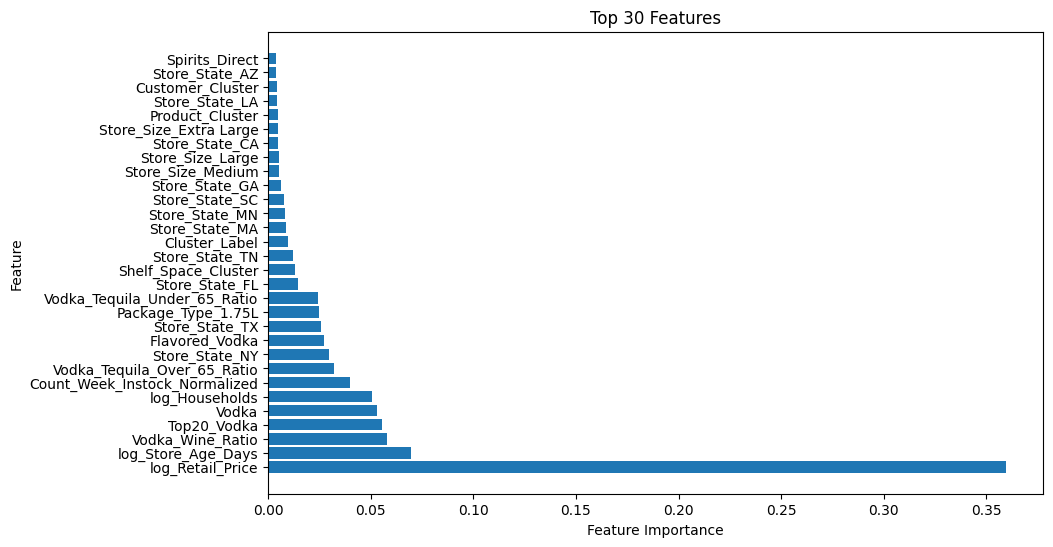

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt

# Train the model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot the top features
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:30], feature_importances['Importance'][:30])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 30 Features")
plt.show()


In [ ]:
# Model Training and Evaluation

# Define features and target
X = data[[ 'log_Retail_Price', 'log_Store_Age_Days', 'Top20_Vodka', 'Vodka_Wine_Ratio', 'log_Households', 'Count_Week_Instock_Normalized',
                'Vodka', 'Vodka_Tequila_Over_65_Ratio', 'Store_State_NY',
                'Flavored_Vodka', 'Store_State_TX', 'Package_Type_1.75L', 'Vodka_Tequila_Under_65_Ratio',
                'Customer_Cluster', 'Product_Cluster', 'Store_State_FL', 'Store_State_TN', 'Cluster_Label', 'Shelf_Space_Cluster',
                 'Store_State_MN', 'Store_State_SC', 'Store_State_MA', 'Store_State_GA', 'Store_Size_Large', 'Store_Size_Extra Large',
                 'Store_Size_Medium', 'Store_State_CA', 'Store_State_LA', 'Store_State_AZ', 'Store_Size_Small'

]]
y = data['Normalized_Sales_$L52W']

# Split into train, validation, and holdout sets
X_train_val, X_holdout, y_train_val, y_holdout = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Preprocessing pipeline
numerical_features = [ 'Count_Week_Instock_Normalized','log_Retail_Price', 'log_Store_Age_Days','Vodka_Wine_Ratio', 'log_Households'
 ,'Vodka', 'Vodka_Tequila_Over_65_Ratio', 'Store_State_NY', 'Store_State_TX', 'Package_Type_1.75L', 'Vodka_Tequila_Under_65_Ratio',
                'Customer_Cluster', 'Product_Cluster', 'Store_State_FL', 'Store_State_TN', 'Cluster_Label', 'Shelf_Space_Cluster',
                 'Store_State_MN', 'Store_State_SC', 'Store_State_MA', 'Store_State_GA', 'Store_Size_Large', 'Store_Size_Extra Large',
                 'Store_Size_Medium', 'Store_State_CA', 'Store_State_LA', 'Store_State_AZ', 'Store_Size_Small']
categorical_features = [col for col in X.columns if col not in numerical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', 'passthrough', categorical_features)
    ]
)

In [ ]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression

linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('linear_regression', LinearRegression())
])

# Train the Linear Regression model
linear_pipeline.fit(X_train, y_train)

# Evaluate Linear Regression model
y_train_pred_lr = linear_pipeline.predict(X_train)
y_val_pred_lr = linear_pipeline.predict(X_val)

train_rmse_lr = mean_squared_error(y_train, y_train_pred_lr, squared=False)
val_rmse_lr = mean_squared_error(y_val, y_val_pred_lr, squared=False)

print("Linear Regression Model Performance:")
print(f"Training RMSE: {train_rmse_lr:.4f}")
print(f"Validation RMSE: {val_rmse_lr:.4f}")

Linear Regression Model Performance:
Training RMSE: 16183.4006
Validation RMSE: 16805.2907


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Ridge Regression Model
from sklearn.linear_model import RidgeCV

ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge_regression', RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5))
])

# Train the Ridge Regression model
ridge_pipeline.fit(X_train, y_train)

# Evaluate Ridge Regression model
y_train_pred_ridge = ridge_pipeline.predict(X_train)
y_val_pred_ridge = ridge_pipeline.predict(X_val)

train_rmse_ridge = mean_squared_error(y_train, y_train_pred_ridge, squared=False)
val_rmse_ridge = mean_squared_error(y_val, y_val_pred_ridge, squared=False)

print("Ridge Regression Model Performance:")
print(f"Training RMSE: {train_rmse_ridge:.4f}")
print(f"Validation RMSE: {val_rmse_ridge:.4f}")

Ridge Regression Model Performance:
Training RMSE: 16183.4009
Validation RMSE: 16805.3521


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Lasso Regression Model
from sklearn.linear_model import LassoCV

lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso_regression', LassoCV(cv=5, random_state=2424))
])

# Train the Lasso Regression model
lasso_pipeline.fit(X_train, y_train)

# Evaluate Lasso Regression model
y_train_pred_lasso = lasso_pipeline.predict(X_train)
y_val_pred_lasso = lasso_pipeline.predict(X_val)

train_rmse_lasso = mean_squared_error(y_train, y_train_pred_lasso, squared=False)
val_rmse_lasso = mean_squared_error(y_val, y_val_pred_lasso, squared=False)

print("Lasso Regression Model Performance:")
print(f"Training RMSE: {train_rmse_lasso:.4f}")
print(f"Validation RMSE: {val_rmse_lasso:.4f}")

Lasso Regression Model Performance:
Training RMSE: 16184.2140
Validation RMSE: 16808.3919


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# XGBoost Model
xgboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgboost', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=400,           # Reduce trees to avoid overfitting
        learning_rate=0.03,         # Lower learning rate for stability
        max_depth=5,                # Lower depth to reduce complexity
        subsample=0.7,              # Increase randomness
        colsample_bytree=0.7,       # Increase randomness
        reg_alpha=1,                # L1 regularization
        reg_lambda=1,               # L2 regularization
        min_child_weight=5,         # Avoid overfitting small leaf nodes
        random_state=2424
    ))
])

# Train the XGBoost model
xgboost_pipeline.fit(X_train, y_train)

# Evaluate XGBoost model
y_train_pred_xgb = xgboost_pipeline.predict(X_train)
y_val_pred_xgb = xgboost_pipeline.predict(X_val)
y_holdout_pred_xgb = xgboost_pipeline.predict(X_holdout)

# Calculate RMSE and MAE for training, validation, and holdout sets
train_rmse_xgb = mean_squared_error(y_train, y_train_pred_xgb, squared=False)
val_rmse_xgb = mean_squared_error(y_val, y_val_pred_xgb, squared=False)
holdout_rmse_xgb = mean_squared_error(y_holdout, y_holdout_pred_xgb, squared=False)

train_mae_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
val_mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
holdout_mae_xgb = mean_absolute_error(y_holdout, y_holdout_pred_xgb)

# Calculate R² for training, validation, and holdout sets
train_r2_xgb = xgboost_pipeline.score(X_train, y_train)
val_r2_xgb = xgboost_pipeline.score(X_val, y_val)
holdout_r2_xgb = xgboost_pipeline.score(X_holdout, y_holdout)

# Print metrics
print("XGBoost Model Performance:")
print(f"Training RMSE: {train_rmse_xgb:.4f}, MAE: {train_mae_xgb:.4f}, R²: {train_r2_xgb:.4f}")
print(f"Validation RMSE: {val_rmse_xgb:.4f}, MAE: {val_mae_xgb:.4f}, R²: {val_r2_xgb:.4f}")
print(f"Holdout RMSE: {holdout_rmse_xgb:.4f}, MAE: {holdout_mae_xgb:.4f}, R²: {holdout_r2_xgb:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBoost Model Performance:
Training RMSE: 13818.6432, MAE: 3757.0230, R²: 0.3081
Validation RMSE: 15309.5379, MAE: 4038.1502, R²: 0.2187
Holdout RMSE: 16265.4023, MAE: 4093.4524, R²: 0.2523


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Updated boosting models
xgboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgboost', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_estimators=350,       # Adjusted for smoother convergence
        learning_rate=0.025,    # Lower learning rate
        max_depth=6,            # Balanced depth for validation
        reg_alpha=1.8,          # Adjusted L1 regularization
        reg_lambda=2.2,         # Adjusted L2 regularization
        subsample=0.85,         # Controlled subsampling
        colsample_bytree=0.9,
        min_child_weight=7      # Adjusted for generalization
    ))
])

lightgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lightgbm', LGBMRegressor(
        objective='regression',
        random_state=42,
        n_estimators=350,
        learning_rate=0.025,
        max_depth=7,            # Slightly deeper trees for richer splits
        reg_alpha=1.8,
        reg_lambda=2.2,
        num_leaves=25,          # Balanced leaf count
        subsample=0.85,
        colsample_bytree=0.9
    ))
])

catboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('catboost', CatBoostRegressor(
        verbose=0,
        random_state=42,
        iterations=350,
        learning_rate=0.025,
        depth=6,               # Balanced depth
        l2_leaf_reg=4.0,       # Regularization for generalization
        subsample=0.85,
        early_stopping_rounds=50
    ))
])

adaboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('adaboost', AdaBoostRegressor(
        random_state=42,
        n_estimators=300,      # Balanced estimator count
        learning_rate=0.025    # Lower learning rate for smoother fit
    ))
])

random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('random_forest', RandomForestRegressor(
        random_state=42,
        n_estimators=250,
        max_depth=8,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt'
    ))
])

# Updated ensemble model
ensemble_model = VotingRegressor(
    estimators=[
        ('xgboost', xgboost_pipeline),
        ('lightgbm', lightgbm_pipeline),
        ('catboost', catboost_pipeline),
        ('adaboost', adaboost_pipeline),
        ('random_forest', random_forest_pipeline)
    ],
    weights=[1.6, 1.6, 0.5, 0.4, 0.5]  # Increased emphasis on XGBoost and LightGBM
)

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Evaluate the ensemble model
y_train_pred_ensemble = ensemble_model.predict(X_train)
y_val_pred_ensemble = ensemble_model.predict(X_val)
y_holdout_pred_ensemble = ensemble_model.predict(X_holdout)

train_rmse_ensemble = mean_squared_error(y_train, y_train_pred_ensemble, squared=False)
val_rmse_ensemble = mean_squared_error(y_val, y_val_pred_ensemble, squared=False)
holdout_rmse_ensemble = mean_squared_error(y_holdout, y_holdout_pred_ensemble, squared=False)

train_mae_ensemble = mean_absolute_error(y_train, y_train_pred_ensemble)
val_mae_ensemble = mean_absolute_error(y_val, y_val_pred_ensemble)
holdout_mae_ensemble = mean_absolute_error(y_holdout, y_holdout_pred_ensemble)

train_r2_ensemble = ensemble_model.score(X_train, y_train)
val_r2_ensemble = ensemble_model.score(X_val, y_val)
holdout_r2_ensemble = ensemble_model.score(X_holdout, y_holdout)

# Print results
print("Final Updated Ensemble Model Performance:")
print(f"Training RMSE: {train_rmse_ensemble:.4f}, MAE: {train_mae_ensemble:.4f}, R²: {train_r2_ensemble:.4f}")
print(f"Validation RMSE: {val_rmse_ensemble:.4f}, MAE: {val_mae_ensemble:.4f}, R²: {val_r2_ensemble:.4f}")
print(f"Holdout RMSE: {holdout_rmse_ensemble:.4f}, MAE: {holdout_mae_ensemble:.4f}, R²: {holdout_r2_ensemble:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 39523, number of used features: 55
[LightGBM] [Info] Start training from score 3927.968702


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Final Updated Ensemble Model Performance:
Training RMSE: 13438.9400, MAE: 3636.0848, R²: 0.3456
Validation RMSE: 14832.3911, MAE: 3895.9902, R²: 0.2666
Holdout RMSE: 15461.7492, MAE: 3921.5072, R²: 0.3244


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Feature scaling and preprocessing pipeline
xgboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Replace with your preprocessor setup
    ('xgboost', XGBRegressor(objective='reg:squarederror', random_state=2424))
])

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'xgboost__n_estimators': [300, 500, 700],
    'xgboost__max_depth': [5, 7, 9],
    'xgboost__learning_rate': [0.01, 0.03, 0.05],
    'xgboost__subsample': [0.6, 0.7, 0.8],
    'xgboost__colsample_bytree': [0.6, 0.7, 0.8],
    'xgboost__min_child_weight': [1, 3, 5],
    'xgboost__reg_alpha': [0.1, 0.5, 1],
    'xgboost__reg_lambda': [1, 2, 3]
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    xgboost_pipeline,
    param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='r2',
    verbose=2,
    n_jobs=-1
)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Extract the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Cross-Validation R²:", best_score)

# Evaluate the best model on validation and holdout sets
y_val_pred_best = best_model.predict(X_val)
y_holdout_pred_best = best_model.predict(X_holdout)

# Calculate metrics for the best model
val_rmse_best = mean_squared_error(y_val, y_val_pred_best, squared=False)
val_mae_best = mean_absolute_error(y_val, y_val_pred_best)
val_r2_best = r2_score(y_val, y_val_pred_best)

holdout_rmse_best = mean_squared_error(y_holdout, y_holdout_pred_best, squared=False)
holdout_mae_best = mean_absolute_error(y_holdout, y_holdout_pred_best)
holdout_r2_best = r2_score(y_holdout, y_holdout_pred_best)

# Print the evaluation metrics
print("\nBest Model Performance on Validation Set:")
print(f"RMSE: {val_rmse_best:.4f}, MAE: {val_mae_best:.4f}, R²: {val_r2_best:.4f}")

print("\nBest Model Performance on Holdout Set:")
print(f"RMSE: {holdout_rmse_best:.4f}, MAE: {holdout_mae_best:.4f}, R²: {holdout_r2_best:.4f}")


Fitting 3 folds for each of 6561 candidates, totalling 19683 fits


KeyboardInterrupt: 

In [ ]:
# Random Forest Model
random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('random_forest', RandomForestRegressor(
        n_estimators=500,
        max_depth=10,
        min_samples_split=5,
        random_state=2424
    ))
])

# Train the Random Forest model
random_forest_pipeline.fit(X_train, y_train)

# Evaluate Random Forest model
y_train_pred_rf = random_forest_pipeline.predict(X_train)
y_val_pred_rf = random_forest_pipeline.predict(X_val)
y_holdout_pred_rf = random_forest_pipeline.predict(X_holdout)

# Calculate RMSE and MAE for training, validation, and holdout sets
train_rmse_rf = mean_squared_error(y_train, y_train_pred_rf, squared=False)
val_rmse_rf = mean_squared_error(y_val, y_val_pred_rf, squared=False)
holdout_rmse_rf = mean_squared_error(y_holdout, y_holdout_pred_rf, squared=False)

train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
val_mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
holdout_mae_rf = mean_absolute_error(y_holdout, y_holdout_pred_rf)

# Calculate R² for training, validation, and holdout sets
train_r2_rf = random_forest_pipeline.score(X_train, y_train)
val_r2_rf = random_forest_pipeline.score(X_val, y_val)
holdout_r2_rf = random_forest_pipeline.score(X_holdout, y_holdout)

# Print metrics
print("RF Model Performance:")
print(f"Training RMSE: {train_rmse_rf:.4f}, MAE: {train_mae_rf:.4f}, R²: {train_r2_rf:.4f}")
print(f"Validation RMSE: {val_rmse_rf:.4f}, MAE: {val_mae_rf:.4f}, R²: {val_r2_rf:.4f}")
print(f"Holdout RMSE: {holdout_rmse_rf:.4f}, MAE: {holdout_mae_rf:.4f}, R²: {holdout_r2_rf:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RF Model Performance:
Training RMSE: 11684.5762, MAE: 3144.5660, R²: 0.5053
Validation RMSE: 15206.0002, MAE: 3579.2310, R²: 0.2292
Holdout RMSE: 14875.7852, MAE: 3660.1621, R²: 0.3746


In [ ]:
# Ensemble Model (XGBoost + Random Forest)
ensemble_model_xgb_rf = VotingRegressor(
    estimators=[('xgboost', xgboost_pipeline), ('random_forest', random_forest_pipeline)],
    weights=[.7, .3]
)

# Train the ensemble model
ensemble_model_xgb_rf.fit(X_train, y_train)

# Evaluate Ensemble model
y_train_pred_ensemble = ensemble_model_xgb_rf.predict(X_train)
y_val_pred_ensemble = ensemble_model_xgb_rf.predict(X_val)
y_holdout_pred_ensemble = ensemble_model_xgb_rf.predict(X_holdout)

train_rmse_ensemble_xgb_rf = mean_squared_error(y_train, y_train_pred_ensemble, squared=False)
val_rmse_ensemble_xgb_rf = mean_squared_error(y_val, y_val_pred_ensemble, squared=False)
holdout_rmse_ensemble_xgb_rf = mean_squared_error(y_holdout, y_holdout_pred_ensemble, squared=False)

print("Ensemble Model Performance:")
print(f"Training RMSE: {train_rmse_ensemble_xgb_rf:.4f}")
print(f"Validation RMSE: {val_rmse_ensemble_xgb_rf:.4f}")
print(f"Holdout RMSE: {holdout_rmse_ensemble_xgb_rf:.4f}")

Ensemble Model Performance:
Training RMSE: 11902.2004
Validation RMSE: 15457.1170
Holdout RMSE: 15749.0562


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Neural Network Model
# Preprocess data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_holdout_preprocessed = preprocessor.transform(X_holdout)

# Define the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_preprocessed.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train_preprocessed, y_train,
    epochs=60,
    batch_size=40,
    validation_data=(X_val_preprocessed, y_val),
    verbose=0
)

# Evaluate the neural network model
y_train_pred_nn = model.predict(X_train_preprocessed).flatten()
y_val_pred_nn = model.predict(X_val_preprocessed).flatten()
y_holdout_pred_nn = model.predict(X_holdout_preprocessed).flatten()

train_rmse_nn = mean_squared_error(y_train, y_train_pred_nn, squared=False)
val_rmse_nn = mean_squared_error(y_val, y_val_pred_nn, squared=False)
holdout_rmse_nn = mean_squared_error(y_holdout, y_holdout_pred_nn, squared=False)

print("Neural Network Model Performance:")
print(f"Training RMSE: {train_rmse_nn:.4f}")
print(f"Validation RMSE: {val_rmse_nn:.4f}")
print(f"Holdout RMSE: {holdout_rmse_nn:.4f}")

172/172 [==============================] - 0s 1ms/step
Neural Network Model Performance:
Training RMSE: 14965.3845
Validation RMSE: 16413.2656
Holdout RMSE: 16989.0748


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Define the new boosting models
lightgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lightgbm', LGBMRegressor(
        n_estimators=500,       # Number of boosting rounds
        learning_rate=0.05,     # Shrinkage rate
        max_depth=7,            # Maximum depth of a tree
        num_leaves=31,          # Number of leaves
        subsample=0.8,          # Subsample ratio of the training instances
        colsample_bytree=0.8,   # Subsample ratio of columns when constructing each tree
        random_state=42
    ))
])

catboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('catboost', CatBoostRegressor(
        iterations=500,         # Number of boosting iterations
        learning_rate=0.05,     # Shrinkage rate
        depth=6,                # Depth of the tree
        l2_leaf_reg=3.0,        # L2 regularization coefficient
        random_strength=1.0,    # Random strength for scoring splits
        subsample=0.8,          # Subsample ratio of the training instances
        verbose=0,              # Suppress output
        random_state=42
    ))
])

adaboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('adaboost', AdaBoostRegressor(
        n_estimators=200,       # Number of boosting rounds
        learning_rate=0.1,      # Shrinkage rate
        loss='square',          # Loss function ('linear', 'square', 'exponential')
        random_state=42
    ))
])

xgboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgboost', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=500,       # Number of boosting rounds
        learning_rate=0.05,     # Shrinkage rate
        max_depth=6,            # Maximum depth of a tree
        subsample=0.8,          # Subsample ratio of the training instances
        colsample_bytree=0.8,   # Subsample ratio of columns when constructing each tree
        random_state=2424
    ))
])

random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('random_forest', RandomForestRegressor(
        n_estimators=300,       # Number of trees in the forest
        max_depth=10,           # Maximum depth of the tree
        min_samples_split=5,    # Minimum number of samples required to split a node
        min_samples_leaf=3,     # Minimum number of samples required at each leaf node
        max_features='sqrt',    # Number of features to consider when looking for the best split
        random_state=42
    ))
])

# Updated Ensemble Model with additional boosting models
ensemble_model_final = VotingRegressor(
    estimators=[
        ('xgboost', xgboost_pipeline),
        ('random_forest', random_forest_pipeline),
        ('lightgbm', lightgbm_pipeline),
        ('catboost', catboost_pipeline),
        ('adaboost', adaboost_pipeline)
    ],
    weights=[1, 1, 1, 1, 1]  # Equal weight for all models
)

# Train the ensemble model
ensemble_model_final.fit(X_train, y_train)

# Evaluate the Ensemble model
y_train_pred_ensemble = ensemble_model_final.predict(X_train)
y_val_pred_ensemble = ensemble_model_final.predict(X_val)
y_holdout_pred_ensemble = ensemble_model_final.predict(X_holdout)

# Calculate RMSE and MAE for training, validation, and holdout sets
train_rmse_ensemble_final = mean_squared_error(y_train, y_train_pred_ensemble, squared=False)
val_rmse_ensemble_final = mean_squared_error(y_val, y_val_pred_ensemble, squared=False)
holdout_rmse_ensemble_final = mean_squared_error(y_holdout, y_holdout_pred_ensemble, squared=False)

train_mae_ensemble_final = mean_absolute_error(y_train, y_train_pred_ensemble)
val_mae_ensemble_final = mean_absolute_error(y_val, y_val_pred_ensemble)
holdout_mae_ensemble_final = mean_absolute_error(y_holdout, y_holdout_pred_ensemble)

# Calculate R² for training, validation, and holdout sets
train_r2_ensemble_final = ensemble_model_final.score(X_train, y_train)
val_r2_ensemble_final = ensemble_model_final.score(X_val, y_val)
holdout_r2_ensemble_final = ensemble_model_final.score(X_holdout, y_holdout)

# Print results
print("Enhanced Ensemble Model Performance:")
print(f"Training RMSE: {train_rmse_ensemble_final:.4f}, MAE: {train_mae_ensemble_final:.4f}, R²: {train_r2_ensemble_final:.4f}")
print(f"Validation RMSE: {val_rmse_ensemble_final:.4f}, MAE: {val_mae_ensemble_final:.4f}, R²: {val_r2_ensemble_final:.4f}")
print(f"Holdout RMSE: {holdout_rmse_ensemble_final:.4f}, MAE: {holdout_mae_ensemble_final:.4f}, R²: {holdout_r2_ensemble_final:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 910
[LightGBM] [Info] Number of data points in the train set: 39523, number of used features: 30
[LightGBM] [Info] Start training from score 3927.968702


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Enhanced Ensemble Model Performance:
Training RMSE: 12673.1411, MAE: 3490.7871, R²: 0.4181
Validation RMSE: 14802.4964, MAE: 3869.6403, R²: 0.2696
Holdout RMSE: 15939.7716, MAE: 3893.7425, R²: 0.2820


# Predictions

In [ ]:
# Redefine dummy data for fitting
X_excluded = pred[[ 'log_Retail_Price', 'log_Store_Age_Days', 'Top20_Vodka', 'Vodka_Wine_Ratio', 'log_Households', 'Count_Week_Instock_Normalized',
                'Vodka', 'Vodka_Tequila_Over_65_Ratio', 'Store_State_NY',
                'Flavored_Vodka', 'Store_State_TX', 'Package_Type_1.75L', 'Vodka_Tequila_Under_65_Ratio',
                'Customer_Cluster', 'Product_Cluster', 'Store_State_FL', 'Store_State_TN', 'Cluster_Label', 'Shelf_Space_Cluster',
                 'Store_State_MN', 'Store_State_SC', 'Store_State_MA', 'Store_State_GA', 'Store_Size_Large', 'Store_Size_Extra Large',
                 'Store_Size_Medium', 'Store_State_CA', 'Store_State_LA', 'Store_State_AZ', 'Store_Size_Small'

]]

# Predict with ensemble model
y_excluded_pred = ensemble_model_final.predict(X_excluded)

# Add predictions to the DataFrame
pred['Predicted_Sales'] = y_excluded_pred

# Save predictions to CSV
output_path = "df_excluded_predictions.csv"
pred[['Store_Number', 'Item_Code', 'Predicted_Sales']].to_csv(output_path, index=False)
output_path

<ipython-input-20-6079381b158e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred['Predicted_Sales'] = y_excluded_pred


'df_excluded_predictions.csv'